In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block.
    """
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Sequential(         
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x) 

class EncoderBlock(nn.Module):
    """
    Encoder block with Conv2d, BatchNorm2d, ReLU, and SEBlock.
    Uses stride=2 for downsampling.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, reduction=16):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DecoderBlock(nn.Module):
    """
    Decoder block with ConvTranspose2d, Skip Connection, 1x1 Conv, BatchNorm2d, ReLU.
    """
    def __init__(self, in_channels, convt_out_channels, skip_channels, final_out_channels, kernel_size=5, stride=2, padding=2, output_padding=1):
        super(DecoderBlock, self).__init__()
        self.convt = nn.ConvTranspose2d(in_channels, convt_out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)
        self.conv1x1 = nn.Conv2d(convt_out_channels + skip_channels, final_out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(final_out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
        x = self.convt(x)
        if x.shape[-2:] != skip_connection.shape[-2:]:
            skip_connection = F.interpolate(skip_connection, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv1x1(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class TransformerEncoderLayer(nn.Module):
    """
    Standard Transformer Encoder Layer.
    """
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TF_GridNet_Block(nn.Module):
    """
    Single block of TF-GridNet, containing Time-LSTM, Freq-LSTM, and Transformer.
    """
    def __init__(self, in_channels, hidden_channels, nhead=8, num_transformer_layers=1):
        super().__init__()
        self.time_lstm = nn.LSTM(input_size=in_channels, hidden_size=hidden_channels, batch_first=True)
        self.freq_lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels, batch_first=True) # Freq LSTM input comes from Time LSTM output
        
        self.transformer_layers = nn.ModuleList(
            [TransformerEncoderLayer(d_model=hidden_channels, nhead=nhead) for _ in range(num_transformer_layers)]
        )
        
        self.norm_t = nn.LayerNorm(in_channels)
        self.norm_f = nn.LayerNorm(hidden_channels)
        self.norm_tr = nn.LayerNorm(hidden_channels)

    def forward(self, x):
        B, C, F, T = x.shape
        
        x_t = x.permute(0, 2, 3, 1).reshape(B * F, T, C)
        x_t = self.norm_t(x_t)
        t_lstm_out, _ = self.time_lstm(x_t) 
        
        x_f = t_lstm_out.reshape(B, F, T, -1).permute(0, 2, 1, 3).reshape(B * T, F, -1)
        x_f = self.norm_f(x_f)
        f_lstm_out, _ = self.freq_lstm(x_f) 
        
        tr_in = self.norm_tr(f_lstm_out)
        for layer in self.transformer_layers:
            tr_out = layer(tr_in) 

        output = tr_out.reshape(B, T, F, -1).permute(0, 3, 2, 1) 
        
        return output

class GridNet(nn.Module):
    """
    Stacks multiple TF_GridNet_Blocks.
    """
    def __init__(self, in_channels, hidden_channels, nhead=8, num_transformer_layers=1, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList()
        current_channels = in_channels
        for _ in range(num_blocks):
            self.blocks.append(
                TF_GridNet_Block(current_channels, hidden_channels, nhead, num_transformer_layers)
            )
            current_channels = hidden_channels 

        self.final_conv = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.final_conv(x)
        return x


class X_TF_GridNet(nn.Module):
    def __init__(self, input_channels=8, gridnet_hidden=256, nhead=8, num_gridnet_blocks=3, output_channels=2):
        super(X_TF_GridNet, self).__init__()

        self.output_channels = output_channels

        self.enc1 = EncoderBlock(input_channels, 32) 
        self.enc2 = EncoderBlock(32, 64)  
        self.enc3 = EncoderBlock(64, 128)    
        self.enc4 = EncoderBlock(128, 256)        
        self.bottleneck_conv = EncoderBlock(256, gridnet_hidden) 

        self.gridnet = GridNet(in_channels=gridnet_hidden, hidden_channels=gridnet_hidden, 
                               nhead=nhead, num_blocks=num_gridnet_blocks)
        
        self.dec1 = DecoderBlock(gridnet_hidden, 256, 256, 256) 

        self.dec2 = DecoderBlock(256, 128, 128, 128) 

        self.dec3 = DecoderBlock(128, 64, 64, 64)   

        self.dec4 = DecoderBlock(64, 32, 32, 32)    

        self.final_convt = nn.ConvTranspose2d(32, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.final_activation = nn.Sigmoid() 

    def forward(self, x):
        B, C, F, T, complex_dim = x.shape
        assert complex_dim == 2, "Input tensor must have complex dimension 2 (real, imag)"
        x = x.permute(0, 4, 1, 2, 3).reshape(B, 2 * C, F, T)

        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        bottleneck = self.bottleneck_conv(e4) 

        grid_out = self.gridnet(bottleneck) 

        d1 = self.dec1(grid_out, e4)
        d2 = self.dec2(d1, e3)
        d3 = self.dec3(d2, e2)
        d4 = self.dec4(d3, e1)

        out = self.final_convt(d4) 

        out = out.permute(0, 2, 3, 1) 

        return out

if __name__ == '__main__':
    print("Testing X-TF-GridNet model...")

    batch_size = 2
    input_channels_complex = 4
    frequency_bins = 256 
    time_frames = 128    
    complex_dim = 2

    input_tensor = torch.randn(batch_size, input_channels_complex, frequency_bins, time_frames, complex_dim)

    model = X_TF_GridNet(input_channels=input_channels_complex * complex_dim,
                         gridnet_hidden=256,
                         nhead=8,        
                         num_gridnet_blocks=3,
                         output_channels=complex_dim)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_tensor = input_tensor.to(device)

    print(f"Input tensor shape: {input_tensor.shape}")
    
    try:
        with torch.no_grad():
            output_tensor = model(input_tensor)

        print("Model forward pass successful.")
        print("Input shape:", input_tensor.shape)
        print("Output shape:", output_tensor.shape)

        expected_output_shape = (batch_size, frequency_bins, time_frames, complex_dim)
        print("Expected output shape:", expected_output_shape)
        assert output_tensor.shape == expected_output_shape
        print("Output shape matches expected shape.")

    except Exception as e:
        print(f"An error occurred during forward pass: {e}")
        import traceback
        traceback.print_exc()

Testing X-TF-GridNet model...
Input tensor shape: torch.Size([2, 4, 256, 128, 2])
Model forward pass successful.
Input shape: torch.Size([2, 4, 256, 128, 2])
Output shape: torch.Size([2, 256, 128, 2])
Expected output shape: (2, 256, 128, 2)
Output shape matches expected shape.


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np 


def calculate_stft_domain_losses(model_output_ri, noisy_stft_ri_target_mic_processed, clean_stft_target_ri_processed, lambda_lsm=1.0, epsilon=1e-8):
    
    predicted_mask_complex = torch.complex(model_output_ri[:, 0, :, :], model_output_ri[:, 1, :, :]) # (B, F, T)
    noisy_stft_complex_processed = torch.complex(noisy_stft_ri_target_mic_processed[:, 0, :, :], noisy_stft_ri_target_mic_processed[:, 1, :, :]) # (B, F, T)
    clean_stft_complex_processed = torch.complex(clean_stft_target_ri_processed[:, 0, :, :], clean_stft_target_ri_processed[:, 1, :, :]) # (B, F, T)

    predicted_enhanced_stft_complex_processed = predicted_mask_complex * noisy_stft_complex_processed # (B, F, T)

    predicted_mag_processed = torch.abs(predicted_enhanced_stft_complex_processed) # (B, F, T)
    clean_mag_processed = torch.abs(clean_stft_complex_processed) # (B, F, T)

    magnitude_l1_loss = F.l1_loss(predicted_mag_processed, clean_mag_processed)


    sc_loss = torch.norm(predicted_mag_processed - clean_mag_processed, p='fro') / (torch.norm(clean_mag_processed, p='fro') + epsilon)


    log_pred_mag_processed = torch.log(predicted_mag_processed + epsilon)
    log_clean_mag_processed = torch.log(clean_mag_processed + epsilon)
    lsm_mse_loss = F.mse_loss(log_pred_mag_processed, log_clean_mag_processed) 


    combined_sc_lsm_loss = sc_loss + lambda_lsm * lsm_mse_loss

    losses = {
        "magnitude_l1": magnitude_l1_loss,
        "sc": sc_loss,
        "lsm_mse": lsm_mse_loss,
        "combined_sc_lsm": combined_sc_lsm_loss
    }

    return losses


In [ ]:
import os
import h5py
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class L3DAS_Total_HDF5_Dataset(Dataset):
    def __init__(self, h5_file_path, train=True, val_split=0.1):
        self.h5_file_path = h5_file_path
        self.train = train
        self.val_split = val_split
        self.file = None
        self.x_data = None
        self.y_data = None
        self.indices = None
        self._load_data()
        self._split_data()

    def _load_data(self):
        self.file = h5py.File(self.h5_file_path, 'r')
        if 'x' in self.file and 'y' in self.file:
            self.x_data = self.file['x']
            self.y_data = self.file['y']
            self.total_len = len(self.y_data)
        else:
            raise KeyError(f"'{self.h5_file_path}' 檔案中找不到 'x' 或 'y' dataset。")

    def _split_data(self):
        val_len = int(self.total_len * self.val_split)
        train_len = self.total_len - val_len
        all_indices = list(range(self.total_len))
        train_indices, val_indices = random_split(all_indices, [train_len, val_len], generator=torch.Generator().manual_seed(42)) # 使用固定 seed 以確保可重複性

        if self.train:
            self.indices = sorted(list(train_indices))
        else:
            self.indices = sorted(list(val_indices))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_index = self.indices[idx]
        x = self.x_data[original_index]
        y = self.y_data[original_index]
        return torch.as_tensor(x, dtype=torch.float32), torch.as_tensor(y, dtype=torch.float32)

    def __del__(self):
        if self.file:
            self.file.close()

if __name__ == '__main__':
    h5_file = 'total.h5' 
    val_split_ratio = 0.2

    train_dataset = L3DAS_Total_HDF5_Dataset(h5_file, train=True, val_split=val_split_ratio)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

    val_dataset = L3DAS_Total_HDF5_Dataset(h5_file, train=False, val_split=val_split_ratio)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    print(f"訓練集大小: {len(train_dataset)} 個樣本")
    print(f"驗證集大小: {len(val_dataset)} 個樣本")

    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        print(f"訓練批次 {i+1} x 的形狀:", batch_x.shape)
        print(f"訓練批次 {i+1} y 的形狀:", batch_y.shape)
        break

    for i, (batch_x, batch_y) in enumerate(val_dataloader):
        print(f"驗證批次 {i+1} x 的形狀:", batch_x.shape)
        print(f"驗證批次 {i+1} y 的形狀:", batch_y.shape)
        break

訓練集大小: 42701 個樣本
驗證集大小: 10675 個樣本
訓練批次 1 x 的形狀: torch.Size([64, 4, 256, 128, 2])
訓練批次 1 y 的形狀: torch.Size([64, 256, 128, 2])
驗證批次 1 x 的形狀: torch.Size([64, 4, 256, 128, 2])
驗證批次 1 y 的形狀: torch.Size([64, 256, 128, 2])


In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
dropout_rate = 0.3 

model = X_TF_GridNet(input_channels=input_channels_complex * complex_dim,
                         gridnet_hidden=256, 
                         nhead=8,          
                         num_gridnet_blocks=3, 
                         output_channels=complex_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) 

scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95) 

MODEL_SAVE_DIR = 'checkpoints'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')

num_epochs = 160 
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf') 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 
    running_mag_l1_loss = 0.0
    running_sc_loss = 0.0
    running_lsm_mse_loss = 0.0

    for batch_idx, (xb, yb) in enumerate(train_dataloader):
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        model_output_ri = model(xb).permute(0, 3, 1, 2) # (B, 2, 256, 128)

        noisy_stft_ri_target_mic_processed = xb[:, 0, :, :, :].permute(0, 3, 1, 2) # (B, 2, 256, 128)

        clean_stft_target_ri_processed = yb.permute(0, 3, 1, 2) # (B, 2, 256, 128)


        losses = calculate_stft_domain_losses(
            model_output_ri,
            noisy_stft_ri_target_mic_processed,
            clean_stft_target_ri_processed,
            lambda_lsm=1.0 
        )

        loss = losses["combined_sc_lsm"] 

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mag_l1_loss += losses["magnitude_l1"].item()
        running_sc_loss += losses["sc"].item()
        running_lsm_mse_loss += losses["lsm_mse"].item()


    avg_loss = running_loss / len(train_dataloader)
    avg_mag_l1_loss = running_mag_l1_loss / len(train_dataloader)
    avg_sc_loss = running_sc_loss / len(train_dataloader)
    avg_lsm_mse_loss = running_lsm_mse_loss / len(train_dataloader)
    train_loss_history.append(avg_loss)


    model.eval()
    running_val_loss = 0.0
    running_val_mag_l1_loss = 0.0
    running_val_sc_loss = 0.0
    running_val_lsm_mse_loss = 0.0

    with torch.no_grad(): 
        for vbatch_idx, (vxb, vyb) in enumerate(val_dataloader):
            vxb = vxb.to(device)
            vyb = vyb.to(device)

            voutputs = model(vxb).permute(0, 3, 1, 2) # (B, 2, 256, 128)

            v_noisy_stft_ri_target_mic_processed = vxb[:, 0, :, :, :].permute(0, 3, 1, 2) # (B, 2, 256, 128)
            v_clean_stft_target_ri_processed = vyb.permute(0, 3, 1, 2) # (B, 2, 256, 128)

            val_losses = calculate_stft_domain_losses(
                voutputs, 
                v_noisy_stft_ri_target_mic_processed,
                v_clean_stft_target_ri_processed,
                lambda_lsm=1.0 
            )

            val_loss = val_losses["combined_sc_lsm"] 

            running_val_loss += val_loss.item()
            running_val_mag_l1_loss += val_losses["magnitude_l1"].item()
            running_val_sc_loss += val_losses["sc"].item()
            running_val_lsm_mse_loss += val_losses["lsm_mse"].item()


    avg_val_loss = running_val_loss / len(val_dataloader)
    avg_val_mag_l1_loss = running_val_mag_l1_loss / len(val_dataloader)
    avg_val_sc_loss = running_val_sc_loss / len(val_dataloader)
    avg_val_lsm_mse_loss = running_val_lsm_mse_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_loss:.6f} (Mag L1: {avg_mag_l1_loss:.6f}, SC: {avg_sc_loss:.6f}, LSM MSE: {avg_lsm_mse_loss:.6f}) | "
          f"Val Loss: {avg_val_loss:.6f} (Mag L1: {avg_val_mag_l1_loss:.6f}, SC: {avg_val_sc_loss:.6f}, LSM MSE: {avg_val_lsm_mse_loss:.6f}) | "
          f"LR: {scheduler.get_last_lr()[0]:.6e}")


    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"驗證損失降低 ({best_val_loss:.6f})，儲存模型參數到 {BEST_MODEL_PATH}")
        torch.save(model.state_dict(), BEST_MODEL_PATH)

KeyboardInterrupt: 

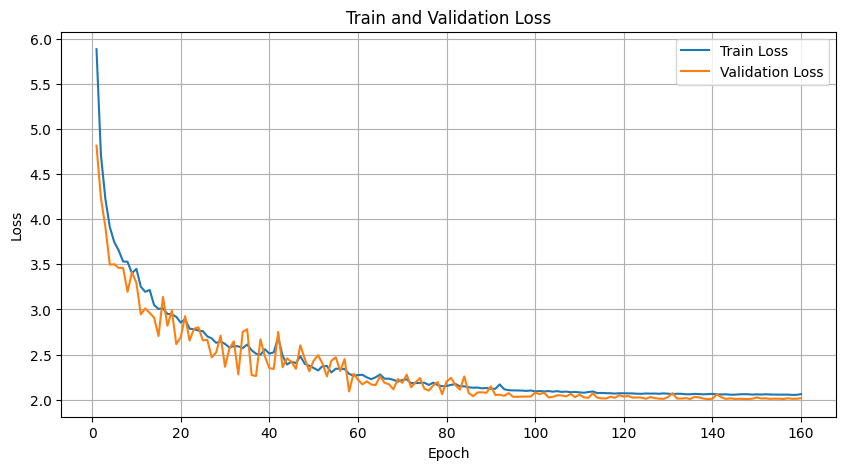

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_save_path = 'complex_crn_model_params.pth'

state_dict = torch.load(model_save_path)


model.load_state_dict(state_dict)

model.eval()

print(f"模型參數已從 {model_save_path} 載入。")

模型參數已從 complex_crn_model_params.pth 載入。


In [ ]:
import os
import numpy as np
import librosa
import torch
import soundfile as sf
import gc 
import torch.nn as nn
import torch.nn.functional as F 

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block.
    """
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Sequential( 
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x) 

class EncoderBlock(nn.Module):
    """
    Encoder block with Conv2d, BatchNorm2d, ReLU, and SEBlock.
    Uses stride=2 for downsampling.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, reduction=16):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels, reduction=reduction)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.se(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, convt_out_channels, skip_channels, final_out_channels, kernel_size=5, stride=2, padding=2, output_padding=1, reduction=16):
        super(DecoderBlock, self).__init__()
        self.convt = nn.ConvTranspose2d(in_channels, convt_out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)

        self.conv1x1 = nn.Conv2d(convt_out_channels + skip_channels, final_out_channels, kernel_size=1)

        self.bn = nn.BatchNorm2d(final_out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(final_out_channels, reduction=reduction)

    def forward(self, x, skip_connection):
        x = self.convt(x) 

        target_shape = skip_connection.shape[-2:] 
        
        if x.shape[-2:] != target_shape:
             x = x[..., :target_shape[0], :target_shape[1]]
             
             if x.shape[-2:] != target_shape:
                  print(f"錯誤或意外: 裁剪後尺寸 {x.shape} 仍與目標尺寸 {skip_connection.shape} 不匹配！請檢查 DecoderBlock 的實現或相關參數。")
        x = torch.cat([x, skip_connection], dim=1) 

        x = self.conv1x1(x) 

        x = self.bn(x)
        x = self.relu(x)
        x = self.se(x)

        return x 


class ComplexCRN(nn.Module):
    """
    Complex Convolutional Recurrent Network (CRN) with SE Blocks and Skip Connections.
    Processes complex-valued audio features (reshaped real/imaginary as channels).
    """
    def __init__(self, input_channels=8, hidden_size=256, num_layers=2, output_channels=2, reduction=16):
        """
        Args:
            input_channels (int): Number of input channels (e.g., 2*num_mics for reshaped complex).
            hidden_size (int): Hidden size of the GRU.
            num_layers (int): Number of layers in the GRU.
            output_channels (int): Number of output channels (e.g., 2 for complex mask).
            reduction (int): Reduction ratio for SE blocks.
        """
        super(ComplexCRN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_channels = output_channels

        self.enc1 = EncoderBlock(input_channels, 32, reduction=reduction)  # Output: (B, 32, F/2, T/2)
        self.enc2 = EncoderBlock(32, 64, reduction=reduction)     # Output: (B, 64, F/4, T/4)
        self.enc3 = EncoderBlock(64, 128, reduction=reduction)    # Output: (B, 128, F/8, T/8)
        self.enc4 = EncoderBlock(128, 256, reduction=reduction)   # Output: (B, 256, F/16, T/16)
        self.enc5 = EncoderBlock(256, 512, reduction=reduction)   # Output: (B, 512, F/32, T/32)

        self.gru = nn.GRU(input_size=512, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True, bidirectional=True)

        self.dec1 = DecoderBlock(in_channels=self.hidden_size * 2, convt_out_channels=256, skip_channels=256, final_out_channels=256, reduction=reduction)

        self.dec2 = DecoderBlock(in_channels=256, convt_out_channels=128, skip_channels=128, final_out_channels=128, reduction=reduction)

        self.dec3 = DecoderBlock(in_channels=128, convt_out_channels=64, skip_channels=64, final_out_channels=64, reduction=reduction)

        self.dec4 = DecoderBlock(in_channels=64, convt_out_channels=32, skip_channels=32, final_out_channels=32, reduction=reduction)

        self.final_convt = nn.ConvTranspose2d(32, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1)


    def forward(self, x):
        B, C, F, T, complex_dim = x.shape
        assert complex_dim == 2,

        x = x.permute(0, 4, 1, 2, 3).reshape(B, 2 * C, F, T) # (B, 8, 256, 128)

        e1 = self.enc1(x) # (B, 32, 128, 64) - F/2, T/2
        e2 = self.enc2(e1) # (B, 64, 64, 32)  - F/4, T/4
        e3 = self.enc3(e2) # (B, 128, 32, 16) - F/8, T/8
        e4 = self.enc4(e3) # (B, 256, 16, 8)  - F/16, T/16
        e5 = self.enc5(e4) # (B, 512, 8, 4)   - F/32, T/32 

        B_enc, C_enc, F_enc, T_enc = e5.shape 
        enc_reshaped = e5.view(B_enc, C_enc, F_enc * T_enc).permute(0, 2, 1) # (B, 32, 512)

        rnn_out, _ = self.gru(enc_reshaped) # (B, 32, hidden_size * 2) - (B, 32, 512)

        rnn_out = rnn_out.permute(0, 2, 1).view(B_enc, self.hidden_size * 2, F_enc, T_enc) # (B, 512, 8, 4)

        d1_out = self.dec1(rnn_out, e4) 

        d2_out = self.dec2(d1_out, e3) 

        d3_out = self.dec3(d2_out, e2) 

        d4_out = self.dec4(d3_out, e1) 

        out = self.final_convt(d4_out)

        out = out.permute(0, 2, 3, 1) 

        return out



def preprocess_segment_for_inference(audio_segment, sr, n_fft, hop_length, target_f, target_t):
    num_channels, seg_samples = audio_segment.shape
    
    num_frames = 1 + (seg_samples - n_fft) // hop_length
    
    padding_t = max(0, target_t - num_frames)
    trim_t = max(0, num_frames - target_t)

    mix_stft = []
    for c in range(num_channels):
        stft_c = librosa.stft(audio_segment[c], n_fft=n_fft, hop_length=hop_length)
        
        stft_c_ri = np.stack([np.real(stft_c), np.imag(stft_c)], axis=-1)

        stft_c_ri_cropped_f = stft_c_ri[:target_f, :, :]

        if padding_t > 0:
             stft_c_ri_processed_t = np.pad(stft_c_ri_cropped_f, ((0, 0), (0, padding_t), (0, 0)), mode='constant')
        elif trim_t > 0:
             stft_c_ri_processed_t = stft_c_ri_cropped_f[:, :target_t, :]
        else: 
             stft_c_ri_processed_t = stft_c_ri_cropped_f

        mix_stft.append(stft_c_ri_processed_t)

    mix_stft_np = np.stack(mix_stft, axis=0)

    mix_stft_tensor = torch.from_numpy(mix_stft_np).float().unsqueeze(0)

    return mix_stft_tensor

def reconstruct_audio_from_predicted_stft(predicted_stft_segment_tensor, n_fft, hop_length, seg_samples):
    predicted_stft_segment_np = predicted_stft_segment_tensor.squeeze(0).cpu().numpy()
    padded_stft_np = np.pad(predicted_stft_segment_np, ((0, 1), (0, 0), (0, 0)), mode='constant')
    
    complex_stft = padded_stft_np[:, :, 0] + 1j * padded_stft_np[:, :, 1]

    audio_segment = librosa.istft(complex_stft, hop_length=hop_length, length=seg_samples)

    return audio_segment


def enhance_audio_file(model, noisy_audio_path, sr, segment_len, n_fft, hop_length, target_f, target_t, device):
    print(f"載入音訊檔案: {noisy_audio_path}")
    mix_audio, _ = librosa.load(noisy_audio_path, sr=sr, mono=False)

    if mix_audio.shape[0] != 4:
        print(f"[錯誤] {noisy_audio_path} 通道不足 4 個。")
        return None

    total_samples = mix_audio.shape[1]
    seg_samples = int(segment_len * sr)
    hop_samples_inference = seg_samples 

    enhanced_audio_segments = []
    
    model.eval()
    with torch.no_grad():
        for i in range(0, total_samples, hop_samples_inference):
            start_sample = i
            end_sample = min(i + seg_samples, total_samples)
            
            mix_segment = mix_audio[:, start_sample:end_sample]

            if mix_segment.shape[1] < seg_samples:
                pad_len = seg_samples - mix_segment.shape[1]
                mix_segment = np.pad(mix_segment, ((0, 0), (0, pad_len)), mode='constant')
            
            input_tensor = preprocess_segment_for_inference(mix_segment, sr, n_fft, hop_length, target_f, target_t)
            
            input_tensor = input_tensor.to(device)

            predicted_stft_tensor = model(input_tensor) 

            enhanced_segment_audio = reconstruct_audio_from_predicted_stft(predicted_stft_tensor, n_fft, hop_length, seg_samples)
            
            enhanced_audio_segments.append(enhanced_segment_audio)
            
            del input_tensor, predicted_stft_tensor, enhanced_segment_audio
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            gc.collect()

    full_enhanced_audio = np.concatenate(enhanced_audio_segments)
    
    full_enhanced_audio = full_enhanced_audio[:total_samples]

    print(f"音訊處理完成，總樣本數: {full_enhanced_audio.shape[0]}")

    return full_enhanced_audio

if __name__ == '__main__':
    SR = 16000
    SEGMENT_LEN = 1.0 
    N_FFT = 512
    HOP_LENGTH = 128
    TARGET_F = 256 
    TARGET_T = 128
    
    MODEL_SAVE_PATH = 'complex_crn_model_params.pth'
    
    TEST_AUDIO_PATH = 'L3DAS22_Task1_dev\data\84-121123-0001_B.wav' 
    OUTPUT_AUDIO_PATH = 'enhanced_output.wav' 

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用裝置: {DEVICE}")

    input_channels_complex = 4 
    complex_dim = 2 
    model = ComplexCRN(
        input_channels=input_channels_complex * complex_dim, 
        hidden_size=256,
        num_layers=2, 
        output_channels=complex_dim, 
        reduction=16 
    )
    model.to(DEVICE)

    if os.path.exists(MODEL_SAVE_PATH):
        try:
            state_dict = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
            model.load_state_dict(state_dict)
            print(f"已從 {MODEL_SAVE_PATH} 載入模型參數。")
        except Exception as e:
            print(f"載入模型參數時發生錯誤: {e}")
            print("請檢查：")
            print("1. 模型參數檔案路徑是否正確。")
            print("2. 當前 ComplexCRN 模型定義是否與訓練時的模型完全一致（包括層、參數）。")
            print("3. 如果模型定義有細微變化，可能需要使用 strict=False (但不推薦，最好模型定義完全一致)。")
            exit() 
    else:
        print(f"錯誤: 找不到模型參數檔案 {MODEL_SAVE_PATH}，無法進行推斷。")
        exit()

    if os.path.exists(TEST_AUDIO_PATH):
        enhanced_audio = enhance_audio_file(
            model, 
            TEST_AUDIO_PATH, 
            SR, SEGMENT_LEN, N_FFT, HOP_LENGTH, 
            TARGET_F, TARGET_T, 
            DEVICE
        )

        if enhanced_audio is not None:
            try:
                sf.write(OUTPUT_AUDIO_PATH, enhanced_audio.astype(np.float32), SR)
                print(f"增強後的音訊已儲存到 {OUTPUT_AUDIO_PATH}")

            except Exception as e:
                print(f"儲存音訊時發生錯誤: {e}")
        else:
            print("音訊增強失敗。")

    else:
        print(f"錯誤: 找不到測試音訊檔案 {TEST_AUDIO_PATH}。")

使用裝置: cuda
已從 complex_crn_model_params.pth 載入模型參數。
載入音訊檔案: L3DAS22_Task1_dev\data\84-121123-0001_B.wav
音訊處理完成，總樣本數: 66239
增強後的音訊已儲存到 enhanced_output.wav
